# Unsupervised 3D Seismic Data Reconstruction Based On Deep Prior

[Fantong Kong](mailto:kft_upc@hotmail.com)<sup>1</sup>,
[Francesco Picetti](mailto:francesco.picetti@polimi.it)<sup>2</sup>,
Vincenzo Lipari<sup>2</sup>, Paolo Bestagini<sup>2</sup>,
Xiaoming Tang<sup>1</sup>, and Stefano Tubaro<sup>2</sup>

1: School of Geosciences - China University of Petroleum (East), Qingdao, China<br>
2: Dipartimento di Elettronica, Informazione e Bioingegneria - Politecnico di Milano, Italy


In this notebook we show our 3D MultiRes UNet workflow for irregular data interpolation on a 3D synthetic 3D dataset that shows simple hyperbolas.

In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings("ignore")
import os
import torch
import numpy as np
from termcolor import colored
from main import Training
import utils as u
from data import get_patch
from argparse import Namespace
import matplotlib.pyplot as plt
from matplotlib import rcParams
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':True
}
rcParams.update(params)

### Parameters

In [2]:
args = Namespace(
    imgdir = './data/',
    outdir = './results/',
    imgname = ['hyperbolic3d.npy'],
    maskname = ['hyperbolic3d_irregular_066.npy'],
    gain = [20.],
    datadim = '3d',
    slice=None,
    imgchannel=1,
    gpu=-1,
    activation='LeakyReLU',
    need_sigmoid=False,
    filters=[16, 32, 64, 128, 256],
    skip=[16, 32, 64, 128],
    inputdepth=64,
    upsample='trilinear',
    inittype='xavier',
    initgain=0.02,
    savemodel=False,
    epochs=3000,
    lr=1e-3,
    save_every=10000,
    loss_max=30.,
    param_noise=False,
    reg_noise_std=0.03,
    noise_dist='n',
    noise_std=.1
)

## Inverse Problem

The Training class is the actual optimization problem

\begin{equation}
    \theta^* = \arg \min_\theta \Vert \mathbf{S} f_\theta(\mathbf{z}) - \mathbf{d}_\text{obs}\Vert_1,
\end{equation}

where $\mathbf{S}$ is the sampling operator we want to invert,
$\mathbf{d}_\text{obs}$ are the acquired coarse and/or irregular data,
$\mathbf{z}$ is a noise tensor that is input of the network,
$f$ is the CNN and $\theta$ its parameters.

The interpolated data are the output of the optimized network: $\mathbf{m}^* = f_{\theta^*}(\mathbf{z})$.


In [3]:
# set the engine to be used
u.set_gpu(args.gpu)
dtype = torch.cuda.FloatTensor
u.set_seed()

GPU selected: 0 - TITAN X (Pascal)


In [4]:
# create output folder
dir_list = list(filter(None, args.imgdir.split('/')))
outpath = os.path.join(args.outdir, 'notebook')
os.makedirs(outpath, exist_ok=True)
print(colored('Saving to %s' % outpath, 'yellow'))

Saving to ./results/notebook


In [5]:
T = Training(args, outpath, dtype=dtype)

### Load data

We subdivide the dataset in 3D patches in order to keep low the GPU memory usage. In this example, however, the dataset is quite small and the GPU memory required is $\approx$ 7.2 GB.

In [6]:
patches_list = get_patch(args)

The number of patches is 1


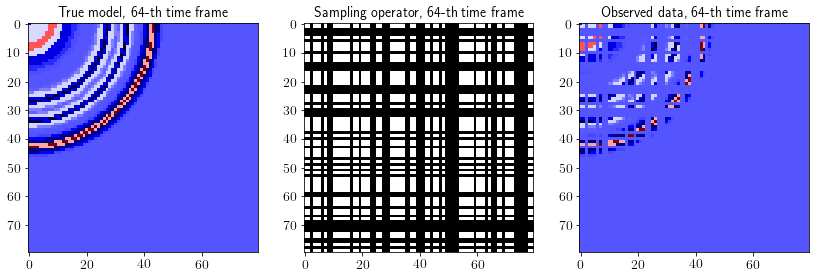

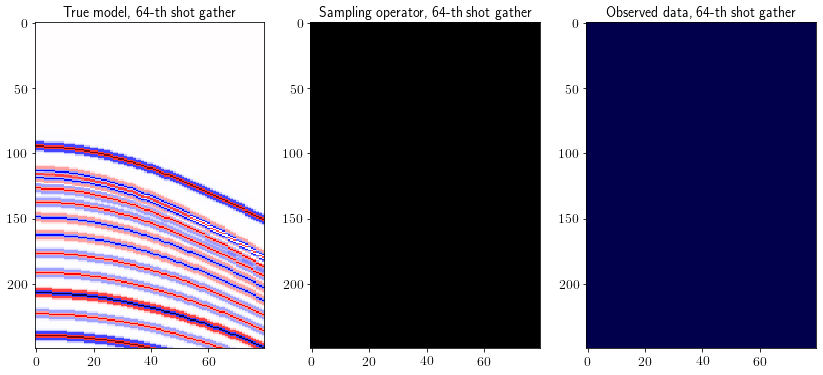

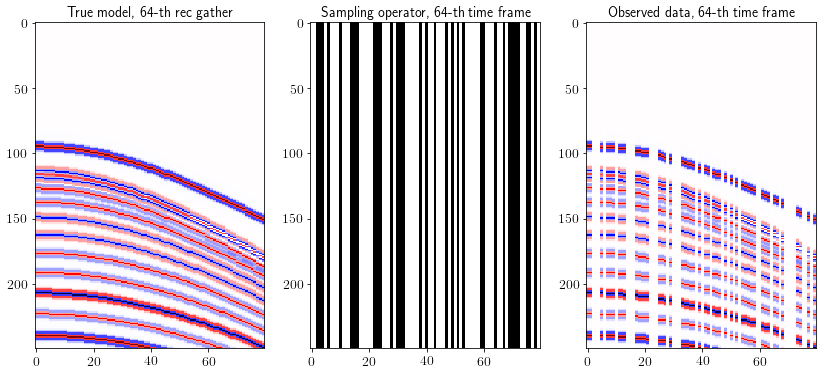

In [17]:
patch = patches_list[0]
t = 64  # time index
x = 64  # receiver index
y = 64  # shot index

plt.figure(figsize=(14,6))
plt.subplot(131), plt.title('True model, %i-th time frame' % t)
plt.imshow(patch['img'][t].squeeze(), cmap='seismic')
plt.subplot(132), plt.title('Sampling operator, %i-th time frame' % t)
plt.imshow(patch['mask'][t].squeeze())
plt.subplot(133), plt.title('Observed data, %i-th time frame' % t)
plt.imshow((patch['img'][t]*patch['mask'][t]).squeeze(), cmap='seismic')
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(131), plt.title('True model, %i-th  shot gather' % y)
plt.imshow(patch['img'][:,y].squeeze(), cmap='seismic', aspect='auto')
plt.subplot(132), plt.title('Sampling operator, %i-th shot gather' % y)
plt.imshow(patch['mask'][:,y].squeeze(), aspect='auto')
plt.subplot(133), plt.title('Observed data, %i-th  shot gather' % y)
plt.imshow((patch['img'][:,y]*patch['mask'][:,y]).squeeze(), cmap='seismic', aspect='auto')
plt.show()

plt.figure(figsize=(14,6))
plt.subplot(131), plt.title('True model, %i-th rec gather' % x)
plt.imshow(patch['img'][:,:,x].squeeze(), cmap='seismic', aspect='auto')
plt.subplot(132), plt.title('Sampling operator, %i-th rec gather' % x)
plt.imshow(patch['mask'][:,:,x].squeeze(), aspect='auto')
plt.subplot(133), plt.title('Observed data, %i-th rec gather' % x)
plt.imshow((patch['img'][:,:,x]*patch['mask'][:,:,x]).squeeze(), cmap='seismic', aspect='auto')
plt.show()

### Optimization

In [19]:
for patch in patches_list:
    imgshape = patch['img'].shape
    print(colored('The image shape is %s ' % (imgshape,), 'green'))
    T.build_input(imgshape)
    T.build_model()
    T.load_data(patch)
    T.optimize()
    T.save_result()
    T.clean()

print(colored('Interpolation done!', 'yellow'))

The image shape is (250, 80, 80, 1) 
The shape of input noise is torch.Size([1, 64, 250, 80, 80]).

initialize network with xavier
the std of input image is 4.704038
Starting optimization with ADAM
1h:25m:16ss = 6.22e-02, SNR = 11.11 dB, PCORR = 9.39e-01  
The image -0 has finished
Interpolation done!


## Results Evaluation

In [24]:
run = np.load(os.path.join(outpath, '0_run.npy'), allow_pickle=True).item()

In [25]:
run.keys()

dict_keys(['device', 'elapsed time', 'run_code', 'history', 'args', 'mask', 'image', 'output'])

In [26]:
output = run['output']

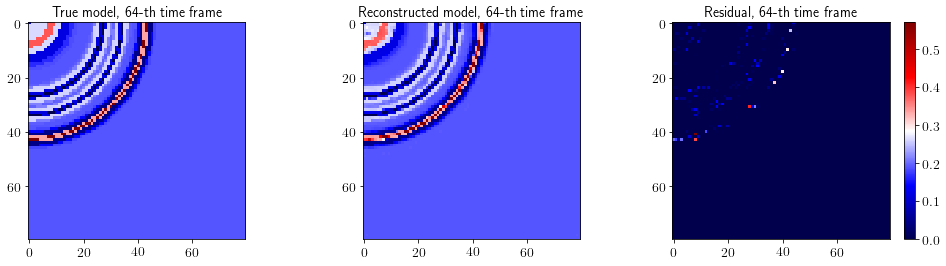

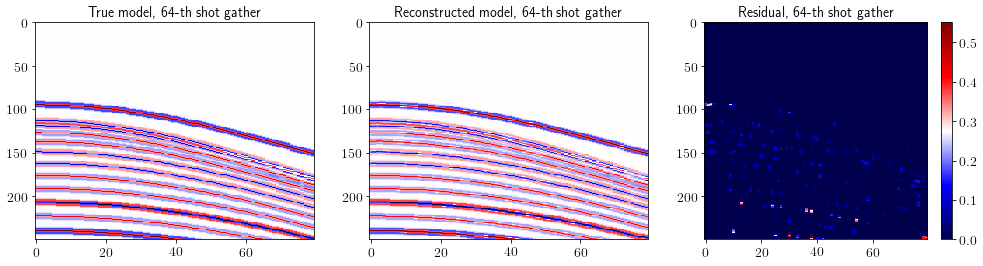

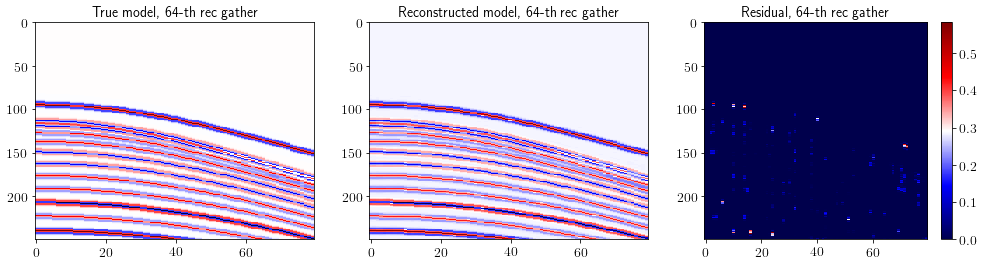

In [51]:
patch = patches_list[0]
t = 64  # time index
x = 64  # receiver index
y = 64  # shot index

normalized_squared_error = (patch['img'].squeeze() - output)**2 / np.max(np.abs(patch['img']))**2

plt.figure(figsize=(17,4))
plt.subplot(131), plt.title('True model, %i-th time frame' % t)
plt.imshow(patch['img'][t].squeeze(), cmap='seismic')
plt.subplot(132), plt.title('Reconstructed model, %i-th time frame' % t)
plt.imshow(output[t].squeeze(), cmap='seismic')
plt.subplot(133), plt.title('Residual, %i-th time frame' % t)
plt.imshow(normalized_squared_error[t].squeeze(), cmap='seismic'), plt.colorbar()
plt.show()

plt.figure(figsize=(17,4))
plt.subplot(131), plt.title('True model, %i-th shot gather' % y)
plt.imshow(patch['img'][:,y].squeeze(), cmap='seismic', aspect='auto')
plt.subplot(132), plt.title('Reconstructed model, %i-th shot gather' % y)
plt.imshow(output[:,y].squeeze(), cmap='seismic', aspect='auto')
plt.subplot(133), plt.title('Residual, %i-th shot gather' % y)
plt.imshow(normalized_squared_error[:,y].squeeze(), cmap='seismic', aspect='auto'), plt.colorbar()
plt.show()

plt.figure(figsize=(17,4))
plt.subplot(131), plt.title('True model, %i-th rec gather' % x)
plt.imshow(patch['img'][:,:,x].squeeze(), cmap='seismic', aspect='auto')
plt.subplot(132), plt.title('Reconstructed model, %i-th rec gather' % x)
plt.imshow(output[:,:,x].squeeze(), cmap='seismic', aspect='auto')
plt.subplot(133), plt.title('Residual, %i-th rec gather' % x)
plt.imshow(normalized_squared_error[:,:,x].squeeze(), cmap='seismic', aspect='auto'), plt.colorbar()
plt.show()

### Check optimization objective function

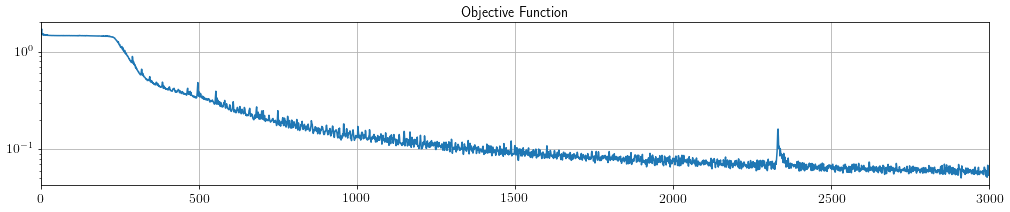

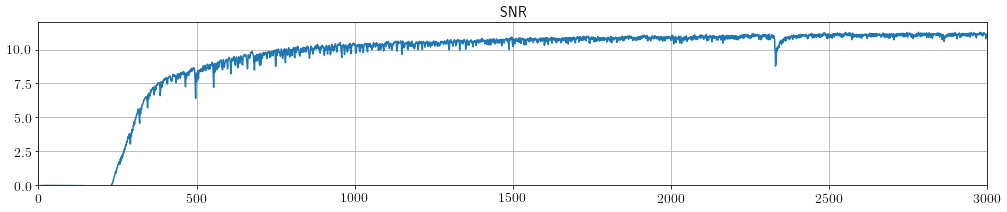

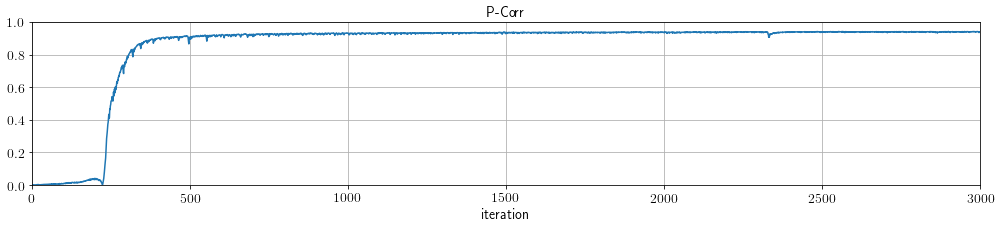

In [81]:
plt.figure(figsize=(17,3))
plt.title('Objective Function')
plt.semilogy(run['history'].loss)
plt.grid(True), plt.xlim(0, 3000), plt.ylim(0, 2)

plt.figure(figsize=(17,3))
plt.title('SNR')
plt.plot(run['history'].snr)
plt.grid(True), plt.xlim(0, 3000), plt.ylim(0, 12)

plt.figure(figsize=(17,3))
plt.title('P-Corr')
plt.plot(np.abs(run['history'].pcorr))
plt.grid(True), plt.xlabel('iteration'), plt.xlim(0, 3000), plt.ylim(0, 1)
plt.show()